# Halo 5 - Visualizations for Increased Engagement and Predicting Victory

- Student name: Johnny Dryman
- Student pace: full time
- Scheduled project review date/time: 7/26/2021
- Instructor name: James Irving

# Introduction

We all had our various ways of getting through the 2020 lockdown - something to keep in touch with people and feel sane.  For me and my friends, we got through it with Halo 5 - specifically their 'Super Fiesta' game mode.  

While we had all played Halo 5 for a short period when it first launched in 2015, we hadn't really touched it since.  Before I even started the data science program at Flatiron, I thought it must somehow be possible to get more data about the game, because my friends and I had a lot of questions we wanted answered.  To name a few that will be addressed in this project:

- How well do we perform on different maps?
- Is there a way to determine whether or not we're improving?
- Why do we get destroyed some rounds and do great other rounds?  

It just so happens that Halo 5 has a very robust API with far more information than I was able to tackle with this project.  Nevertheless, I knew that I would finally be able to answer some questions that my friends and I have had for months.

# Business Problem

343 Industries is on the verge of releasing Halo Infinite, likely the most anticipated game of the decade so far.  The stakes are very high, not just for 343, but also for the millenials that grew up with the game.

It has been said that Halo Infinite will be a "10 year game," with regular updates and maintenance.  How can 343 keep players engaged for that length of time?  Creating a fun experience for players is obviously first and foremost, but based on the information I now know 343 tracks in Halo 5, I would argue that there is room for improved engagement through graphical analysis.  

Further, I believe that by providing more information to the player could position Halo Infinite to break into the 'core' (i.e. hyper competitive) gaming space.  The ability to tell a player they're improving, how well they do on certain maps - more information like this reveals the complexity of the game, and with improved knowledge could bring more engagment and more desire to not only play against others, but play against yourself by improving your own performance figures.

To demonstrate what this might look like, I'll need to pull my entire history of 5903 matches from the API.

# Imports

We'll start by importing some standard Python packages as well as a few other tools that will be useful for this particular projcet.

In [4]:
#Standard Packages
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import pickle
import warnings
warnings.filterwarnings(action='ignore') 

# Packages used for API calls and data processing
import requests
import json
def get_keys(path):
    with open(path) as f:
        return json.load(f)
import ast
import time
import http.client, urllib.request, urllib.parse, urllib.error, base64
api_key = 'ceeaacb7cf024c7485e00ef8457e42dc'
gamertag = 'Drymander'
from tqdm import tqdm
# !pip install isodate
import isodate

# Pull 'Player Match History' from API

The first step will be to pull every game I have ever played from the API.  There will be some valuable information in this data, but mostly, we just want to extract the MatchId's.  

In [5]:
# Setting run equal to false.  If set to true, code will pull all matches for
# user in the gamertag variable
run = False


if run == True:
    # Setting API key and 'start' (0 means most recent match played)
    headers = {
        # Request headers
        'Ocp-Apim-Subscription-Key': api_key,
    }
    start = 0
    matches = []
    
    # Condition to determine whether or not API call has exhausted full match history
    maxed_out = False
    
    # While loop that wil continuously pull from API and terminate once complete
    # When 'count' returns as 25, that means there are more matches to be pulled
    # When 'count' is less than 25, that indicates it is at the end of the player match history
    while maxed_out == False:
        try:
            params = urllib.parse.urlencode({
                # Request parameters
                'modes': 'arena',
                'start': start,
                'count': 25,
                'include-times': True,
            })
            # Code to process the API byte string into a JSON 
            # Will append each JSON to a list
            conn = http.client.HTTPSConnection('www.haloapi.com')
            conn.request("GET", f"/stats/h5/players/{gamertag}/matches?%s" % params, "{body}", headers)
            response = conn.getresponse()
            data = response.read()
            data = json.loads(data)
            matches.extend(data['Results'])
            conn.close()
            
            # If statement to detect final API call
            if data['ResultCount'] == 25:
                maxed_out = False
                time.sleep(1.1)
                start += 25
            else:
                maxed_out = True
        
        # Error handling
        except Exception as e:
            print("error")
    
    # Save to dataframe and CSV
    df = pd.DataFrame(matches)
    df.to_csv('data/DrymanderHistory.csv')



## Extracting info from Player Match History

Now that we have the player match history in a dataframe, we'll need to extract some information.

In [6]:
# Read DrymanderHistory.csv, drop Unnamed: 0 column, show first row
df = pd.read_csv('data/DrymanderHistory.csv')
df = df.drop(['Unnamed: 0'], axis=1)
df.head(1)

,Links,Id,HopperId,MapId,MapVariant,GameBaseVariantId,GameVariant,MatchDuration,MatchCompletedDate,Teams,Players,IsTeamGame,SeasonId,MatchCompletedDateFidelity
0,{'StatsMatchDetails': {'AuthorityId': 'spartan...,{'MatchId': '10010481-1be2-462b-9774-eac5ee152...,f0c9ef9a-48bd-4b24-9db3-2c76b4e23450,d67fdcb9-6d9c-403e-960d-04202e19b244,"{'ResourceType': 3, 'ResourceId': 'beaccaff-81...",a2949322-dc84-45ab-8454-cf94fb28c189,"{'ResourceType': 2, 'ResourceId': 'f213daf2-94...",PT8M48.3224767S,{'ISO8601Date': '2021-07-01T00:55:13.88Z'},"[{'Id': 1, 'Score': 1, 'Rank': 2}, {'Id': 0, '...","[{'Player': {'Gamertag': 'Drymander', 'Xuid': ...",True,NaN,2


It looks like there are quite a few nested dictionaries (dictionaries within dictionaries within dictionaries, etc).  Let's build a function to break out the infromation we need.

In [7]:
# Function to break out columns, many of which are nested dictionaries
def explode_column(df, column):
    # Convert column to string, locate column in dataframe, apply pd.Series
    # which breaks out the nested dictionaries as individual columns
    column = str(column)
    column_loc = df.columns.get_loc(column)
    column_split = df[column].apply(pd.Series)
    
    # Drop column with nested dictionaries and add back key / values as new columns
    df = df.drop(columns=[column])
    df = df.join(column_split, rsuffix=str(column))
    
    # Return dataframe
    return df

In [8]:
# Columns are read from csv as strings, this code converts them back to Python code
df['Id'] = df['Id'].map(ast.literal_eval)
# Explode Id column
df = explode_column(df, 'Id')
df.head(1)

,Links,HopperId,MapId,MapVariant,GameBaseVariantId,GameVariant,MatchDuration,MatchCompletedDate,Teams,Players,IsTeamGame,SeasonId,MatchCompletedDateFidelity,MatchId,GameMode
0,{'StatsMatchDetails': {'AuthorityId': 'spartan...,f0c9ef9a-48bd-4b24-9db3-2c76b4e23450,d67fdcb9-6d9c-403e-960d-04202e19b244,"{'ResourceType': 3, 'ResourceId': 'beaccaff-81...",a2949322-dc84-45ab-8454-cf94fb28c189,"{'ResourceType': 2, 'ResourceId': 'f213daf2-94...",PT8M48.3224767S,{'ISO8601Date': '2021-07-01T00:55:13.88Z'},"[{'Id': 1, 'Score': 1, 'Rank': 2}, {'Id': 0, '...","[{'Player': {'Gamertag': 'Drymander', 'Xuid': ...",True,NaN,2,10010481-1be2-462b-9774-eac5ee152045,1


In [9]:
# Convert strings to dictionaries and explode MapVariant
df['MapVariant'] = df['MapVariant'].map(ast.literal_eval)
df = explode_column(df, 'MapVariant')

df.head(1)

,Links,HopperId,MapId,GameBaseVariantId,GameVariant,MatchDuration,MatchCompletedDate,Teams,Players,IsTeamGame,SeasonId,MatchCompletedDateFidelity,MatchId,GameMode,ResourceType,ResourceId,OwnerType,Owner
0,{'StatsMatchDetails': {'AuthorityId': 'spartan...,f0c9ef9a-48bd-4b24-9db3-2c76b4e23450,d67fdcb9-6d9c-403e-960d-04202e19b244,a2949322-dc84-45ab-8454-cf94fb28c189,"{'ResourceType': 2, 'ResourceId': 'f213daf2-94...",PT8M48.3224767S,{'ISO8601Date': '2021-07-01T00:55:13.88Z'},"[{'Id': 1, 'Score': 1, 'Rank': 2}, {'Id': 0, '...","[{'Player': {'Gamertag': 'Drymander', 'Xuid': ...",True,NaN,2,10010481-1be2-462b-9774-eac5ee152045,1,3,beaccaff-8166-4fe8-94ba-fd18ad7a83e1,3,


In [10]:
# Convert strings to dictionaries and explode GameVariant
df['GameVariant'] = df['GameVariant'].map(ast.literal_eval)
df = explode_column(df, 'GameVariant')

df.head(1)

,Links,HopperId,MapId,GameBaseVariantId,MatchDuration,MatchCompletedDate,Teams,Players,IsTeamGame,SeasonId,MatchCompletedDateFidelity,MatchId,GameMode,ResourceType,ResourceId,OwnerType,Owner,ResourceTypeGameVariant,ResourceIdGameVariant,OwnerTypeGameVariant,OwnerGameVariant
0,{'StatsMatchDetails': {'AuthorityId': 'spartan...,f0c9ef9a-48bd-4b24-9db3-2c76b4e23450,d67fdcb9-6d9c-403e-960d-04202e19b244,a2949322-dc84-45ab-8454-cf94fb28c189,PT8M48.3224767S,{'ISO8601Date': '2021-07-01T00:55:13.88Z'},"[{'Id': 1, 'Score': 1, 'Rank': 2}, {'Id': 0, '...","[{'Player': {'Gamertag': 'Drymander', 'Xuid': ...",True,NaN,2,10010481-1be2-462b-9774-eac5ee152045,1,3,beaccaff-8166-4fe8-94ba-fd18ad7a83e1,3,,2,f213daf2-94f9-46a4-a4d8-b3f782da0bec,3,


In [11]:
# Convert strings to dictionaries and explode GameVariant MatchCompletedDate
df['MatchCompletedDate'] = df['MatchCompletedDate'].map(ast.literal_eval)
df = explode_column(df, 'MatchCompletedDate')

df.head(1)

,Links,HopperId,MapId,GameBaseVariantId,MatchDuration,Teams,Players,IsTeamGame,SeasonId,MatchCompletedDateFidelity,MatchId,GameMode,ResourceType,ResourceId,OwnerType,Owner,ResourceTypeGameVariant,ResourceIdGameVariant,OwnerTypeGameVariant,OwnerGameVariant,ISO8601Date
0,{'StatsMatchDetails': {'AuthorityId': 'spartan...,f0c9ef9a-48bd-4b24-9db3-2c76b4e23450,d67fdcb9-6d9c-403e-960d-04202e19b244,a2949322-dc84-45ab-8454-cf94fb28c189,PT8M48.3224767S,"[{'Id': 1, 'Score': 1, 'Rank': 2}, {'Id': 0, '...","[{'Player': {'Gamertag': 'Drymander', 'Xuid': ...",True,NaN,2,10010481-1be2-462b-9774-eac5ee152045,1,3,beaccaff-8166-4fe8-94ba-fd18ad7a83e1,3,,2,f213daf2-94f9-46a4-a4d8-b3f782da0bec,3,,2021-07-01T00:55:13.88Z


In [12]:
# Convert strings to dictionaries and explode GameVariant Teams
df['Teams'] = df['Teams'].map(ast.literal_eval)
df = explode_column(df, 'Teams')

df.head(1)

,Links,HopperId,MapId,GameBaseVariantId,MatchDuration,Players,IsTeamGame,SeasonId,MatchCompletedDateFidelity,MatchId,GameMode,ResourceType,ResourceId,OwnerType,Owner,ResourceTypeGameVariant,ResourceIdGameVariant,OwnerTypeGameVariant,OwnerGameVariant,ISO8601Date,0,1,2,3,4,5,6,7,8,9,10,11
0,{'StatsMatchDetails': {'AuthorityId': 'spartan...,f0c9ef9a-48bd-4b24-9db3-2c76b4e23450,d67fdcb9-6d9c-403e-960d-04202e19b244,a2949322-dc84-45ab-8454-cf94fb28c189,PT8M48.3224767S,"[{'Player': {'Gamertag': 'Drymander', 'Xuid': ...",True,NaN,2,10010481-1be2-462b-9774-eac5ee152045,1,3,beaccaff-8166-4fe8-94ba-fd18ad7a83e1,3,,2,f213daf2-94f9-46a4-a4d8-b3f782da0bec,3,,2021-07-01T00:55:13.88Z,"{'Id': 1, 'Score': 1, 'Rank': 2}","{'Id': 0, 'Score': 2, 'Rank': 1}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# Convert strings to dictionaries and explode GameVariant Teams
df['Players'] = df['Players'].map(ast.literal_eval)
explode_column(df, 'Players').head(1)

# Handling 'Players' differently since it has nested dictionaries within nested dictionaries
# Breaking out 'Players'
df_players = df['Players'].apply(pd.Series)

# Converting the columns from integers to strings
df_players.columns = df_players.columns.astype(str)

# Exploding the '0' column as its own dataframe
df_players_explode = explode_column(df_players, '0')

# Exploding a more deeply nested 'Player' column
df_match_stats = explode_column(df_players_explode, 'Player')

# Appending results to main dataframe
df = df.join(df_match_stats, rsuffix='_stats')

df.head(1)

,Links,HopperId,MapId,GameBaseVariantId,MatchDuration,Players,IsTeamGame,SeasonId,MatchCompletedDateFidelity,MatchId,GameMode,ResourceType,ResourceId,OwnerType,Owner,ResourceTypeGameVariant,ResourceIdGameVariant,OwnerTypeGameVariant,OwnerGameVariant,ISO8601Date,0,1,2,3,4,5,6,7,8,9,10,11,TeamId,Rank,Result,TotalKills,TotalDeaths,TotalAssists,PreMatchRatings,PostMatchRatings,Gamertag,Xuid
0,{'StatsMatchDetails': {'AuthorityId': 'spartan...,f0c9ef9a-48bd-4b24-9db3-2c76b4e23450,d67fdcb9-6d9c-403e-960d-04202e19b244,a2949322-dc84-45ab-8454-cf94fb28c189,PT8M48.3224767S,"[{'Player': {'Gamertag': 'Drymander', 'Xuid': ...",True,NaN,2,10010481-1be2-462b-9774-eac5ee152045,1,3,beaccaff-8166-4fe8-94ba-fd18ad7a83e1,3,,2,f213daf2-94f9-46a4-a4d8-b3f782da0bec,3,,2021-07-01T00:55:13.88Z,"{'Id': 1, 'Score': 1, 'Rank': 2}","{'Id': 0, 'Score': 2, 'Rank': 1}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2,3,11,9,6,None,None,Drymander,None


We'll go ahead and load the data from a .csv to make sure we're working with the same information throughout the rest of the notebook.

In [15]:
df = pd.read_csv('data/DrymanderHistoryExplode.csv')
df.head(1)

,Unnamed: 0,Links,HopperId,MapId,GameBaseVariantId,MatchDuration,Players,IsTeamGame,SeasonId,MatchCompletedDateFidelity,MatchId,GameMode,ResourceType,ResourceId,OwnerType,Owner,ResourceTypeGameVariant,ResourceIdGameVariant,OwnerTypeGameVariant,OwnerGameVariant,ISO8601Date,2,3,4,5,6,7,8,9,10,11,Id,Score,Rank,Id1,Score1,Rank1,TeamId,Rank_stats,Result,TotalKills,TotalDeaths,TotalAssists,PreMatchRatings,PostMatchRatings,Gamertag,Xuid
0,0,{'StatsMatchDetails': {'AuthorityId': 'spartan...,f0c9ef9a-48bd-4b24-9db3-2c76b4e23450,d67fdcb9-6d9c-403e-960d-04202e19b244,a2949322-dc84-45ab-8454-cf94fb28c189,PT8M48.3224767S,"[{'Player': {'Gamertag': 'Drymander', 'Xuid': ...",True,NaN,2,10010481-1be2-462b-9774-eac5ee152045,1,3,beaccaff-8166-4fe8-94ba-fd18ad7a83e1,3,NaN,2,f213daf2-94f9-46a4-a4d8-b3f782da0bec,3,NaN,2021-07-01T00:55:13.88Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,2,0,2,1,0,2,3,11,9,6,NaN,NaN,Drymander,NaN


Truthfully there's not a ton of useful information in this particular API call, but it does have the essential piece of data we need to pull the information that is useful, the MatchId.  

# Pull All Matches from 'Match Result - Arena' API Call

Now that we have all the match ID's, we'll use each ID to call the Halo 5 API to give us more extensive match information.

In [16]:
# Setting run equal to false.  If set to true, code will pull all matches for
run = False

if run == True:
    
    # Setting API key
    headers = {
        # Request headers
        'Ocp-Apim-Subscription-Key': api_key,
    }
    params = urllib.parse.urlencode({
    })
    
    # Setting match_list to every MatchId in the player history dataframe
    match_list = df['MatchId']
    # Instantiating empty list to append API results
    match_details = []
    # Counter variable
    i = 0
    
    # This loop will pull extensive match details for every MatchId in the player
    # history dataframe and add each match to the match_details list
    for match in match_list:
        try:
            conn = http.client.HTTPSConnection('www.haloapi.com')
            conn.request("GET", f"/stats/h5/arena/matches/{match}?%s" % params, "{body}", headers)
            response = conn.getresponse()
            data = response.read()
            data = json.loads(data)
            match_details.append(data)
            conn.close()
            i += 1
            time.sleep(1.1)

        except Exception as e:
            print("error")

# If run == False, this will load previously compiled match_details from pickle
else: 
    with open('data/match_details.pkl', 'rb') as match_details:
        match_results = pickle.load(match_details)

# Show match details, should be 5903
len(match_results)

5903

Now we have every match in JSON format, and we'll need to convert that into a more palatable format like a dataframe.  We'll start off by saving our player match history dataframe from earlier and starting a new one with just date and match ID.

In [17]:
# Saving our original datafarme as df_history
df_history = df.copy()

In [18]:
# Instantiating new dataframe
df = pd.DataFrame()

# Converting dates to a more readable format
df['Date'] = df_history['ISO8601Date']
df['Date'] = df['Date'].apply(pd.to_datetime)

# Adding MatchId from df_history
df['MatchId'] = df_history['MatchId']

df.head(5)

,Date,MatchId
0,2021-07-01 00:55:13.880000+00:00,10010481-1be2-462b-9774-eac5ee152045
1,2021-07-01 00:49:29.519000+00:00,d8964123-992f-4dd9-8555-40b76a98d4e1
2,2021-07-01 00:40:43.086000+00:00,c86a93e7-4842-4443-9b90-875b20e3846e
3,2021-07-01 00:32:49.388000+00:00,79379ee7-036c-4c4a-9945-ef6eec06fed8
4,2021-07-01 00:24:59.974000+00:00,f16ebbe7-3ddd-4ff8-92de-52904c282d26


# Compile Match Dataframe

Now we'll go through every match to pull out infromation we want for our analysis.  We'll define the stats we want to pull out in the cell below and arrange them in a dataframe.

In [19]:
# List of stats we want to collect from our list of match dictionaries
# These are player specific
inner_stats = [
            'TeamId',
            'Rank',
            'DNF',
            'AvgLifeTimeOfPlayer',
            'PlayerScore',
            'GameEndStatus',
            'TotalKills',
            'TotalHeadshots',
            'TotalWeaponDamage',
            'TotalShotsFired',
            'TotalShotsLanded',
            'TotalMeleeKills',
            'TotalMeleeDamage',
            'TotalAssassinations',
            'TotalGroundPoundKills',
            'TotalGroundPoundDamage',
            'TotalShoulderBashKills',
            'TotalShoulderBashDamage',
            'TotalGrenadeDamage',
            'TotalPowerWeaponKills',
            'TotalPowerWeaponDamage',
            'TotalPowerWeaponGrabs',
            'TotalPowerWeaponPossessionTime',
            'TotalDeaths',
            'TotalAssists',
            'TotalGamesCompleted',
            'TotalGamesWon',
            'TotalGamesLost',
            'TotalGamesTied',
            'TotalTimePlayed',
            'TotalGrenadeKills',
            'TotalSpartanKills',
              ]

# Stats collected for each game that are not player specific
outer_stats = [
            'TotalDuration',
            'MapVariantId',
            'GameVariantId',
            'PlaylistId',
            'MapVariantId',
            'GameBaseVariantId'
]

In [20]:
# New dataframe to compile match details
all_matches_df = pd.DataFrame()
# Setting match count which will help loop through the match list
match_count = 0

# Loop that will collect data by sifting through all JSONs in our match list
for match in tqdm(match_results):
    match_dic = {}
    i=0
    
    # Loop that identifies gamertag within match JSONs
    for player in match['PlayerStats']:
        if match['PlayerStats'][i]['Player']['Gamertag'] == gamertag:
            gamertag_stats = match['PlayerStats'][i]
        else:
            i += 1
    
    # Appending inner stats (gamertag specific)
    for stat in inner_stats:
        match_dic[stat] = gamertag_stats[stat]
    
    # Appending outer stats (match specific)
    for stat in outer_stats:
        match_dic[stat] = match[stat]
    
    # Create one row dataframe from appended stats
    single_match_df = pd.DataFrame.from_records([match_dic])
    # Append that one row dataframe to all_matches_df
    all_matches_df = all_matches_df.append(single_match_df, ignore_index=True)

# Adding date column and MatchId
all_matches_df['Date'] = df['Date'].apply(pd.to_datetime)
all_matches_df['MatchId'] = df_history['MatchId']

100%|██████████| 5903/5903 [01:09<00:00, 85.14it/s] 


# Data Processing and Feature Creation 


Now that we have everything we need from the match details JSON files, we can start preparing our data for analysis.  We'll be transforming some data and creating a few features as well.

In [21]:
# Making copy of all_matches_df so we can work with just df
df = all_matches_df.copy()

df.head(3)

,TeamId,Rank,DNF,AvgLifeTimeOfPlayer,PlayerScore,GameEndStatus,TotalKills,TotalHeadshots,TotalWeaponDamage,TotalShotsFired,TotalShotsLanded,TotalMeleeKills,TotalMeleeDamage,TotalAssassinations,TotalGroundPoundKills,TotalGroundPoundDamage,TotalShoulderBashKills,TotalShoulderBashDamage,TotalGrenadeDamage,TotalPowerWeaponKills,TotalPowerWeaponDamage,TotalPowerWeaponGrabs,TotalPowerWeaponPossessionTime,TotalDeaths,TotalAssists,TotalGamesCompleted,TotalGamesWon,TotalGamesLost,TotalGamesTied,TotalTimePlayed,TotalGrenadeKills,TotalSpartanKills,TotalDuration,MapVariantId,GameVariantId,PlaylistId,GameBaseVariantId,Date,MatchId
0,0,2,False,PT19.0101779S,0,3,11,1,1333.918901,231,66,1,80.029148,0,0,0.0,0,0.0,90.000000,9,1086.018900,0,PT2M24.6165S,9,6,0,0,0,0,PT4M50.4721844S,0,11,PT8M48.3224767S,beaccaff-8166-4fe8-94ba-fd18ad7a83e1,f213daf2-94f9-46a4-a4d8-b3f782da0bec,f0c9ef9a-48bd-4b24-9db3-2c76b4e23450,a2949322-dc84-45ab-8454-cf94fb28c189,2021-07-01 00:55:13.880000+00:00,10010481-1be2-462b-9774-eac5ee152045
1,0,2,False,PT27.334877S,14,3,14,0,1824.901194,259,87,2,198.000015,0,0,0.0,0,0.0,50.744907,11,1635.156286,0,PT5M14.0166S,12,1,0,0,0,0,PT7M27.8478311S,0,14,PT7M27.8508336S,8e4831a0-debb-4f4e-ae75-a0834edcb153,04a4099c-8b96-40a7-a341-668d94a10357,f0c9ef9a-48bd-4b24-9db3-2c76b4e23450,257a305e-4dd3-41f1-9824-dfe7e8bd59e1,2021-07-01 00:49:29.519000+00:00,d8964123-992f-4dd9-8555-40b76a98d4e1
2,1,4,False,PT23.8690928S,10,3,10,2,1300.256462,196,47,0,0.000000,0,0,0.0,0,0.0,92.379814,9,1169.076649,0,PT4M8.3165S,12,3,0,0,0,0,PT6M35.1332077S,1,10,PT6M35.1342094S,b82c7fed-4667-43f8-8467-50741a5e1103,1005b609-aed9-4f19-bc3b-e8f0d29465f0,f0c9ef9a-48bd-4b24-9db3-2c76b4e23450,257a305e-4dd3-41f1-9824-dfe7e8bd59e1,2021-07-01 00:40:43.086000+00:00,c86a93e7-4842-4443-9b90-875b20e3846e


In [22]:
# Checking to see that all stats made it within the columns
df.columns

Index(['TeamId', 'Rank', 'DNF', 'AvgLifeTimeOfPlayer', 'PlayerScore',
       'GameEndStatus', 'TotalKills', 'TotalHeadshots', 'TotalWeaponDamage',
       'TotalShotsFired', 'TotalShotsLanded', 'TotalMeleeKills',
       'TotalMeleeDamage', 'TotalAssassinations', 'TotalGroundPoundKills',
       'TotalGroundPoundDamage', 'TotalShoulderBashKills',
       'TotalShoulderBashDamage', 'TotalGrenadeDamage',
       'TotalPowerWeaponKills', 'TotalPowerWeaponDamage',
       'TotalPowerWeaponGrabs', 'TotalPowerWeaponPossessionTime',
       'TotalDeaths', 'TotalAssists', 'TotalGamesCompleted', 'TotalGamesWon',
       'TotalGamesLost', 'TotalGamesTied', 'TotalTimePlayed',
       'TotalGrenadeKills', 'TotalSpartanKills', 'TotalDuration',
       'MapVariantId', 'GameVariantId', 'PlaylistId', 'GameBaseVariantId',
       'Date', 'MatchId'],
      dtype='object')

## Winner Column

In [23]:
# Creating column denoting win / lose / tie
df['WinLoseTie'] = df['GameEndStatus'].map({3:'Victory', 2:'Tie', 1:'Defeat', 0:'Did Not Finish'})

## Converting Time Codes

In [24]:
# List of columns we want to convert
time_columns = ['AvgLifeTimeOfPlayer', 'TotalTimePlayed', 'TotalDuration',
                'TotalPowerWeaponPossessionTime']

# Function to convert time columns into readable formate
def convert_times(df, time_columns):
    for column in time_columns:
        parsed_times = []
        for row in df[column]:
            row = isodate.parse_duration(row).total_seconds() / 60
            parsed_times.append(row)
        df[column] = parsed_times

# Converting time columns
convert_times(df, time_columns)

# Converting average lifetime of player from minute to seconds
df['AvgLifeTimeOfPlayer'] = df['AvgLifeTimeOfPlayer'] * 60

df[['AvgLifeTimeOfPlayer', 'TotalTimePlayed', 'TotalDuration',
    'TotalPowerWeaponPossessionTime']].head(3)

,AvgLifeTimeOfPlayer,TotalTimePlayed,TotalDuration,TotalPowerWeaponPossessionTime
0,19.010178,4.841203,8.805375,2.410275
1,27.334877,7.464131,7.464181,5.233610
2,23.869093,6.585553,6.585570,4.138608


## Decoding GameBaseVariant, PlayListId, MapVariantId

The Halo 5 API loves its codes, and we have to ping their metadata API links in order to decode them.  We'll save the metadata responses as dictionaries, and use them to make our data readable.

In [25]:
# This function will convert codes provided by the API into a readable format
def decode_column(df, column, api_dict):
    
    # Empty list of decoded values
    decoded_list = []
    
    # Loop through each row
    for row in df[column]:
        i = 0
        
        # Loop through API dictionary
        for item in api_dict:
            
            # If code found, append it to list
            if item['id'] == row:
                name = item['name']
                decoded_list.append(name)
            
            # Otherwise keep searching until found
            else:
                i += 1
    
    # Return decoded list
    return decoded_list

In [26]:
# This function will convert maps to readable format
def decode_maps(df, column, api_dict):
    decoded_list = []
    
    # Loop through each row
    for row in df[column]:
        i = 0
        
        # Creating map_count variable
        map_count = len(api_dict)
        
        # For each item in API dictionary
        for item in api_dict:
            
            # If map cannot be found, name 'Custom Map'
            if (i+1) == map_count:
                name = 'Custom Map'
                decoded_list.append(name)
            
            # If found, assign value to code
            elif item['id'] == row:
                name = item['name']
                decoded_list.append(name)
            
            # Otherwise keep looping
            else:
                i += 1
    
    # Return decoded list
    return decoded_list

## GameBaseVariantId

Game Base Variant ID represents the broad category of game type in Halo 5 Arena multiplayer.  This includes types that might sound familiar to some - Capture the Flag, Slayer, Oddball, Breakout, etc.

In [27]:
run = False

if run == True:
    headers = {
        # Request headers
        'Accept-Language': 'en',
        'Ocp-Apim-Subscription-Key': api_key,
    }

    params = urllib.parse.urlencode({
    })

    try:
        conn = http.client.HTTPSConnection('www.haloapi.com')
        conn.request("GET", "/metadata/h5/metadata/game-base-variants?%s" % params, "{body}", headers)
        response = conn.getresponse()
        data = response.read()
        GameBaseVariantId_dic = json.loads(data)
    #     print(data)
        conn.close()
    except Exception as e:
        print("[Errno {0}] {1}".format(e.errno, e.strerror))

    with open('data/GameBaseVariantId.pkl', 'wb') as GameBaseVariantId_pickle:
        pickle.dump(GameBaseVariantId_dic, GameBaseVariantId_pickle)

else:
    with open('data/GameBaseVariantId.pkl', 'rb') as GameBaseVariantId_pickle:
        GameBaseVariantId_dic = pickle.load(GameBaseVariantId_pickle)
    


In [28]:
df['GameBaseVariantId'] = decode_column(df, 'GameBaseVariantId', GameBaseVariantId_dic)

df['GameBaseVariantId'].unique()

array(['Capture the Flag', 'Slayer', 'Strongholds', 'Oddball',
       'Mini-game', 'Big Team Strongholds', 'Infection', 'Breakout',
       'Grifball', 'Big Team Slayer', 'Big Team CTF', 'Big Team Assault',
       'Assault'], dtype=object)

## PlaylistID

Playlist ID represents the subcategory of a Game Base Variant ID.  For examlpe, by far the most prominent playlist ID for me and my friends will be 'Super Fiesta Party,' where players spawn with random weapons.

In [29]:
run = True

if run == True:

    headers = {
        # Request headers
        'Accept-Language': 'en',
        'Ocp-Apim-Subscription-Key': api_key,
    }

    params = urllib.parse.urlencode({
    })

    try:
        conn = http.client.HTTPSConnection('www.haloapi.com')
        conn.request("GET", "/metadata/h5/metadata/playlists?%s" % params, "{body}", headers)
        response = conn.getresponse()
        data = response.read()
        PlaylistId_dic = json.loads(data)
#         print(data)
        conn.close()
    except Exception as e:
        print("[Errno {0}] {1}".format(e.errno, e.strerror))

    with open('data/PlaylistId_dic.pkl', 'wb') as PlaylistId_dic_pickle:
        pickle.dump(PlaylistId_dic, PlaylistId_dic_pickle)
        
else:
    with open('data/PlaylistId_dic.pkl', 'rb') as PlaylistId_dic_pickle:
        PlaylistId_dic = pickle.load(PlaylistId_dic_pickle)

In [30]:
df['PlaylistId'] = decode_column(df, 'PlaylistId', PlaylistId_dic)

df['PlaylistId'].unique()

array(['Super Fiesta Party', 'Big Team Super Fiesta', 'Core Play',
       'Head to Head', 'Big Team Battle', "Rock 'n' Rail", 'SWAT',
       'Action Sack', 'Free-for-All', 'Elimination', '2v2 Competitive',
       'Team Arena', 'Quick Play', 'Community Slayer', 'Roaming King',
       'ODST Slayer', 'Slayer ', 'Husky Raid', 'Holiday Fiesta',
       'Castle Wars CTF', 'Triple Team', 'Grifball',
       'Anniversary Throwback', 'Forerunner Slayer', 'Shotty Snipers',
       'Halo 3 Classic Throwback', 'Infection', 'Mythic Arena',
       'Team Skirmish', 'HCS 2018', 'Breakout', 'Covenant Slayer',
       'Assault'], dtype=object)

In [31]:
df['PlaylistId'].value_counts()

Super Fiesta Party          4903
Big Team Super Fiesta        339
Holiday Fiesta               262
Husky Raid                    70
Slayer                        62
Action Sack                   39
Free-for-All                  25
SWAT                          23
Core Play                     23
Grifball                      21
Anniversary Throwback         16
Roaming King                  14
Team Skirmish                 13
Elimination                   12
Big Team Battle               12
Quick Play                    10
Team Arena                     9
Shotty Snipers                 8
Rock 'n' Rail                  7
Castle Wars CTF                5
Breakout                       5
Halo 3 Classic Throwback       5
2v2 Competitive                4
Triple Team                    4
Infection                      3
Mythic Arena                   2
Community Slayer               1
Covenant Slayer                1
Assault                        1
Head to Head                   1
Forerunner

## MapVariantId

There are a couple of different map codes, but for the Super Fiesta playlist, MapVariantId will be the one we'll want to use.

In [32]:
unique_map_ids = df['MapVariantId'].unique()

run = False

if run == True:

    headers = {
        # Request headers
        'Accept-Language': 'en',
        'Ocp-Apim-Subscription-Key': api_key,
    }

    params = urllib.parse.urlencode({
    })
    map_list = []
    for map_id in tqdm(unique_map_ids):
        try:
            conn = http.client.HTTPSConnection('www.haloapi.com')
            conn.request("GET", f"/metadata/h5/metadata/map-variants/{map_id}?%s" % params, "{body}", headers)
            response = conn.getresponse()
            data = response.read()
            map_dic = json.loads(data)
            map_list.append(map_dic)
    #         print(data)
            conn.close()
            time.sleep(1.1)
        except Exception as e:
            print("[Errno {0}] {1}".format(e.errno, e.strerror))

    with open('data/map_list.pkl', 'wb') as map_list_pickle:
        pickle.dump(map_list, map_list_pickle)

else:
    with open('data/map_list.pkl', 'rb') as map_list_pickle:
        map_list = pickle.load(map_list_pickle)
    

df['MapVariantId'] = decode_maps(df, 'MapVariantId', map_list)

In [33]:
df['MapVariantId'].unique()

array(['Traverse', 'Vestige', 'Russet', 'Hallows', 'Stasis', 'Putput',
       'Coliseum', 'Hourglass', 'Furnace', 'Solstace Vista', 'The Rig',
       'Harmony', 'Downfall', 'Meta Raid', 'Dominus', 'Eden', 'Meta Wave',
       'Raid on the Control Room', 'Reclaimed', 'Plaza', 'Classified ',
       'Fever Pitch', 'Swamp Fever', 'Stand Clear', 'Seclusion', 'Mercy',
       'Echelon', 'Fathom', 'Moa Fields', 'M808b production',
       'Overgrowth', 'Transit', 'Empire', 'Truth', 'Omission', 'Sleipnir',
       'Blood and Stone', 'Gutter', 'Crossbow', 'Palmyra', 'Chill Out',
       'Containment Breach', 'Junglerock', 'Voyager', 'Guillotine',
       'Boulevard', 'Hinterlands', 'Pioneer', 'Dispelled', 'Viking',
       'Port Authority', 'Fossil', 'Panic Attack', 'Traffic Jam',
       'Scavenger', 'Altar', 'Echoes', 'Meander', 'Fracture', 'Ancestor',
       'Eagle Square', 'Game Night', 'Sideswipe', 'Lawnmower Spree',
       'Mantis Arena I', 'Ferindale', 'Regret FFA HCS', 'White Cell',
       'Nig

## K/D and Accuracy Columns

Getting back to feature creation, we'll make K/D and accuracy columns.

K/D is a very standard performance metric in first person shooter games.  Simply put, it's the number of players you eliminate in a match divided by the number of times you are eliminated.  K/D comes from "Kills / Deaths."

Accuracy would also be nice to analyze, and we can calculate it with total shots landed divided by total shots fired.

In [34]:
# Creating columns that are useful in understanding player skill
df['K/D'] = df['TotalKills'] / df['TotalDeaths']
df['Accuracy'] = df['TotalShotsLanded'] / df['TotalShotsFired']

df[['K/D', 'Accuracy']]

,K/D,Accuracy
0,1.222222,0.285714
1,1.166667,0.335907
2,0.833333,0.239796
3,1.187500,0.348668
4,0.200000,0.434211
...,...,...
5898,0.272727,0.122530
5899,0.125000,0.243243
5900,0.384615,0.326316
5901,0.294118,0.228365


In [35]:
# Organizing columns in an order that makes sense
df_columns = ['Date',
            'DNF',
            'GameBaseVariantId',
            'PlaylistId',
            'MapVariantId',
            'WinLoseTie',
            'TotalKills',
            'TotalDeaths',
            'K/D',
            'Accuracy',
            'TotalHeadshots',
            'TotalWeaponDamage',
            'TotalGrenadeKills',
            'TotalGrenadeDamage',
            'AvgLifeTimeOfPlayer',
            'TotalTimePlayed',
            'TotalDuration',
            'MatchId',
             ]

df = df[df_columns]

df.head(2)

,Date,DNF,GameBaseVariantId,PlaylistId,MapVariantId,WinLoseTie,TotalKills,TotalDeaths,K/D,Accuracy,TotalHeadshots,TotalWeaponDamage,TotalGrenadeKills,TotalGrenadeDamage,AvgLifeTimeOfPlayer,TotalTimePlayed,TotalDuration,MatchId
0,2021-07-01 00:55:13.880000+00:00,False,Capture the Flag,Super Fiesta Party,Traverse,Victory,11,9,1.222222,0.285714,1,1333.918901,0,90.000000,19.010178,4.841203,8.805375,10010481-1be2-462b-9774-eac5ee152045
1,2021-07-01 00:49:29.519000+00:00,False,Slayer,Super Fiesta Party,Vestige,Victory,14,12,1.166667,0.335907,0,1824.901194,0,50.744907,27.334877,7.464131,7.464181,d8964123-992f-4dd9-8555-40b76a98d4e1


## Removing Unnecessary Rows

A handy piece of data they provide is a "DNF" metric, wich stands for "Did Not Finish."  For analysis, I won't want to include any games where I did not finish, so we'll remove those.  

In [36]:
# Removing rows where 'DNF' is true (or where player 'Did Not Finish' the match)

df = df.loc[df['DNF'] == False]

df['DNF'].value_counts()

False    5732
Name: DNF, dtype: int64

# Visualizations

Okay!  Now that we have every match in our history and all the relevant match details compiled nicely into one dataframe, it's time to make some visualizations that will hopefully be interesting to players other than just myself.

## Win / Loss / Tie by Month

In general, my friends and I wanted to get a better understanding of how we had improving over time.  A good way to visualize this might be to show the breakdwon of wins, losses, and ties over the various months we had played.

In [37]:
# Setting a copy of df which will be easy to revert to without rerunning all code above
df_predate = df.copy()

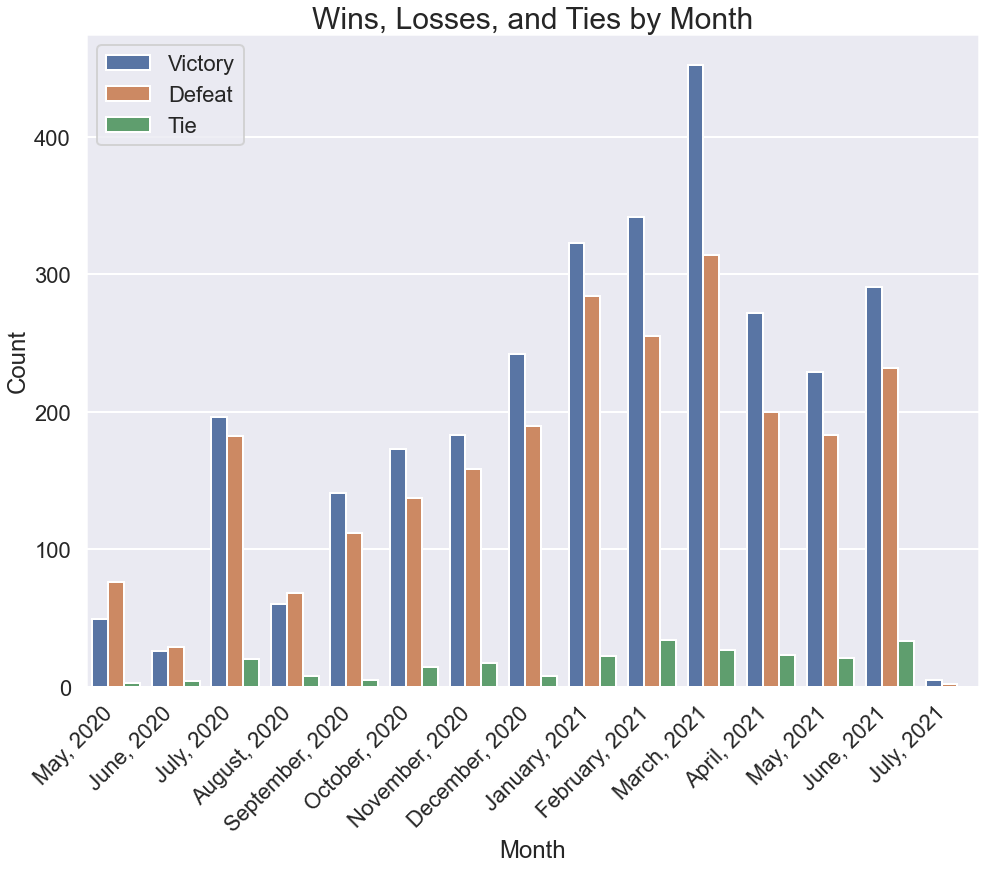

In [38]:
# Loading from copy
df = df_predate.copy()

# Setting seaborn styles
sns.set(rc={'axes.facecolor':'white'})
sns.set_style("darkgrid")
sns.set_context('poster')

# Creating 'Month' column
df['Month'] = pd.to_datetime(df['Date']).dt.to_period('M')
df['Month'] = df['Month'].dt.strftime('%B, %Y')

# Setting time frame of data to visualize
df = df[(df['Date'] > '2020-05-01')]

# Instantiating graph and countplot
f, ax = plt.subplots(figsize=(16, 12))
ax = sns.countplot(x="Month", 
                   data=df.sort_values(by=['Date'], ascending=True), 
                   hue='WinLoseTie',
                   hue_order=['Victory','Defeat','Tie'])

# Setting xtick labels, axis titles, plot titles, and legend order
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, horizontalalignment='right');
ax.set_title('Wins, Losses, and Ties by Month', fontsize=30)
ax.set(ylabel='Count')
plt.legend(labels=['Victory', 'Defeat', 'Tie'])

# Reverting back to original df for convenience with the next visualization
df = df_predate.copy()

We first started playing in May of 2020, and it's pretty clear that I personally did more losing than winning.  Less matches were played in June, but but was improving almost to the point where I was even between wins and losses.  July showed a noticeable bump in matches played, and I finally started winning just a bit more than I was losing.

August was the month where people started to get the false assumption that perhaps it was safe to start associating in person again.  By September, we realized that wasn't the case and you can see my matches played jump right back up.

March is the month I decided to try remapping the buttons on my controller with paddles to allow me to constantly aim while being able to perform the rest of the functions required to play the game.  Judging by the improved win / loss ratio, I would say that not only did the button remapping help me win more, but winning more led to playing more.  

## Win Rate by Map

Another thing that I definitely wanted to know was how well I did on certain maps, specifically in the "Husky Raid" game mode, which is Capture the Flag in the Super Fiesta Party playlist.  Let's see if we can finally answer that question.

In [39]:
# Creating new columns which will be used for counting wins and losses
df['Win'] = df['WinLoseTie'].map({'Victory':1})
df['Lose'] = df['WinLoseTie'].map({'Defeat':1})

In [40]:
# Function to choose gametype
def choose_gametype(df, GameBaseVariantId, PlaylistId):
    
    # If none selected, return df
    # This will be useful for the next function
    if GameBaseVariantId == None and PlaylistId == None:
        gametype_df = df
    
    # Option to set GameBaseVariantId to None
    elif GameBaseVariantId == None:
        gametype_df = df[df['PlaylistId'] == PlaylistId]
    
    # Option to set PlaylistId to None
    elif PlaylistId == None:
        gametype_df = df[df['GameBaseVariantId'] == GameBaseVariantId]
    
    # Set dataframe to specified GameBaseVariantId and PlaylistId
    else:
        gametype_df = df[(df['GameBaseVariantId'] == GameBaseVariantId) & (df['PlaylistId'] == PlaylistId)]
    
    # Return dataframe
    return gametype_df

# Creating new dataframes for husky raid and slayer
husky_df = choose_gametype(df, 'Capture the Flag', 'Super Fiesta Party')
slayer_df = choose_gametype(df, 'Slayer', 'Super Fiesta Party')

In [41]:
# Creating dataframe grouped by WinRate and sum
husky_gb_sum = husky_df.groupby( ["MapVariantId"] ).sum()
husky_gb_sum.reset_index(level=0, inplace=True)
husky_gb_sum['WinRate'] = husky_gb_sum['Win'] / husky_gb_sum['Lose']
husky_gb_sum = husky_gb_sum[~husky_gb_sum.isin([np.nan, np.inf, -np.inf]).any(1)]

husky_gb_sum.head(3)

,MapVariantId,DNF,TotalKills,TotalDeaths,K/D,Accuracy,TotalHeadshots,TotalWeaponDamage,TotalGrenadeKills,TotalGrenadeDamage,AvgLifeTimeOfPlayer,TotalTimePlayed,TotalDuration,Win,Lose,WinRate
0,Blood and Stone,0,1964,2602,157.997519,75.339873,136,252318.403049,43,11589.676155,2531.67524,866.854687,868.907452,110.0,71.0,1.549296
1,Classified,0,1861,1756,103.897660,40.778846,71,235956.888552,32,8005.991636,1460.22443,659.792479,659.825388,40.0,28.0,1.428571
3,Containment Breach,0,1213,1468,76.050042,35.318265,59,151842.806095,18,6353.467373,1459.76296,575.038938,575.070256,43.0,35.0,1.228571


In [42]:
# Creating dataframe grouped by WinRate and mean
husky_gb_mean = husky_df.groupby( ["MapVariantId"] ).mean()
husky_gb_mean.reset_index(level=0, inplace=True)
husky_gb_mean['WinRate'] = husky_gb_mean['Win'] / husky_gb_mean['Lose']
husky_gb_mean = husky_gb_mean[~husky_gb_mean.isin([np.nan, np.inf, -np.inf]).any(1)]

husky_gb_mean.head(3)

,MapVariantId,DNF,TotalKills,TotalDeaths,K/D,Accuracy,TotalHeadshots,TotalWeaponDamage,TotalGrenadeKills,TotalGrenadeDamage,AvgLifeTimeOfPlayer,TotalTimePlayed,TotalDuration,Win,Lose,WinRate
0,Blood and Stone,False,10.791209,14.296703,0.868118,0.413955,0.747253,1386.364852,0.236264,63.679539,13.910304,4.762938,4.774217,1.0,1.0,1.0
1,Classified,False,20.450549,19.296703,1.141733,0.448119,0.780220,2592.932841,0.351648,87.977930,16.046422,7.250467,7.250828,1.0,1.0,1.0
3,Containment Breach,False,13.942529,16.873563,0.874138,0.405957,0.678161,1745.319610,0.206897,73.028361,16.778885,6.609643,6.610003,1.0,1.0,1.0


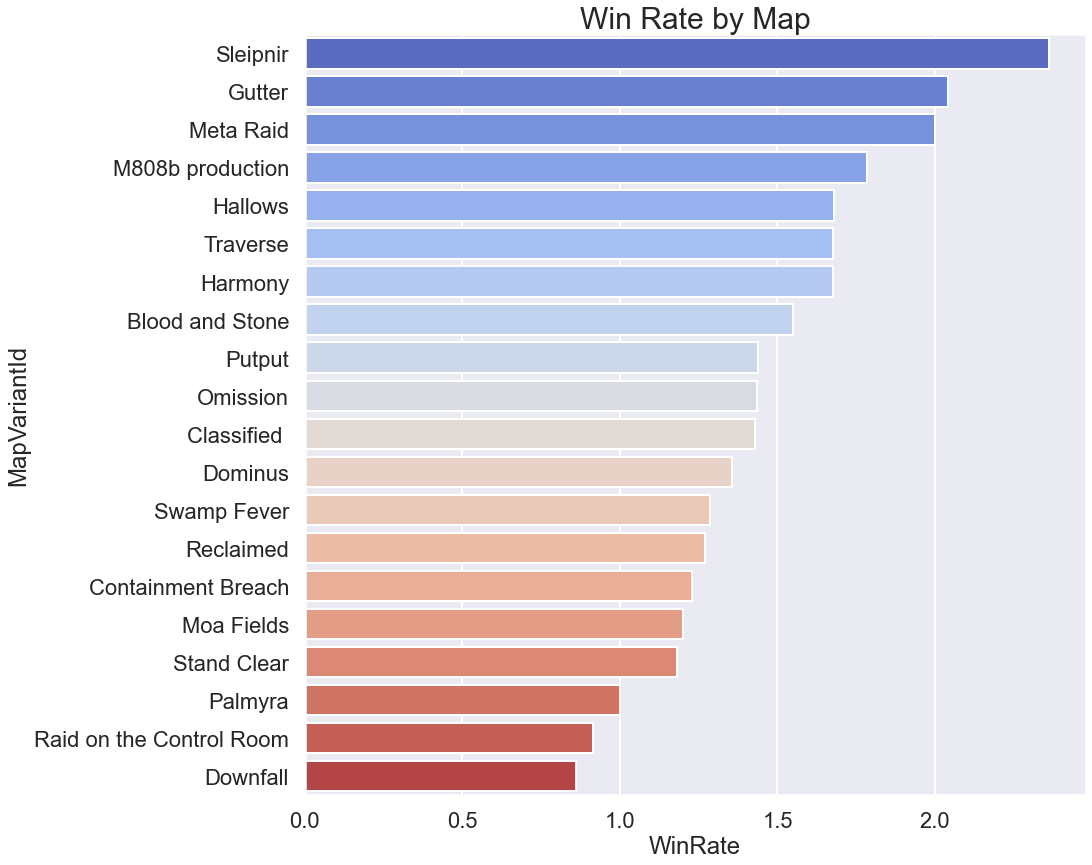

In [43]:
# Function to show column stat broken out by map
def map_plot(df, column, title, x_range=False):
    
    # Initiate seaborn barplot that will sort in descending order from best to worst
    # stat on each map
    f, ax = plt.subplots(figsize=(14, 14))
    ax = sns.barplot(x=column, y='MapVariantId', data=df, 
                order=df.sort_values(column, ascending=False).MapVariantId, 
                palette=('coolwarm'))
    ax.set_title(title, fontsize=30)
    
    # Option to set x axis range within function parameters
    if x_range == False:
        pass
    else:
        ax.set_xlim(x_range[0],x_range[1])

# Plot win rate by map
map_plot(husky_gb_sum, 'WinRate', 'Win Rate by Map')

Not surprisingly, my favorite maps happen to be the ones where my win rate is highest, and my least favorite maps are the ones where my win rate is the lowest.

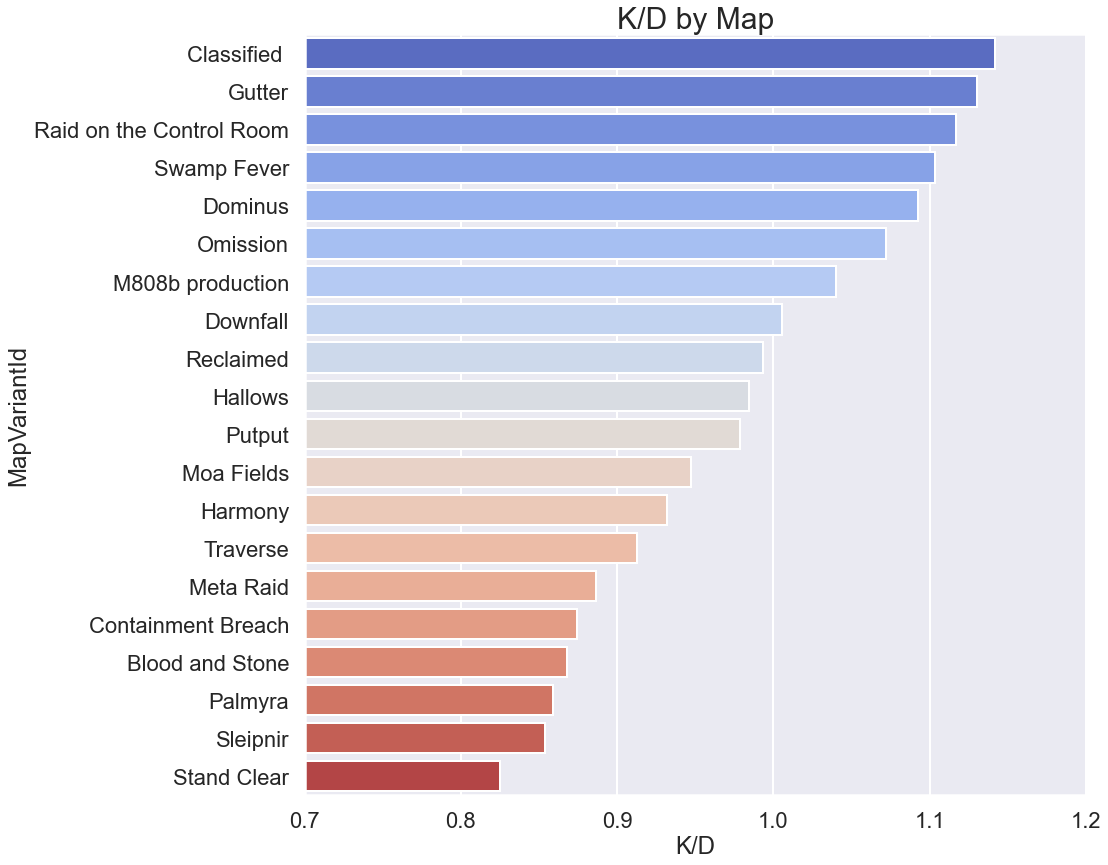

In [44]:
# Plot K/D per map with a range of 0.7-1.2
map_plot(husky_gb_mean, 'K/D', 'K/D by Map', x_range=[0.7,1.2])

Juxtaposing win rate vs. K/D on different maps presents some interesting revelations.

If you look closely, you'll see that my highest win rate is on a map called **Sleipnir**.  However, **Sleipnir** happens to be on of my lowest K/D maps, meaning I die a lot more often than I eliminate an enemy player.  This might reveal how strategy is more important than just elminating your oponents in games of capture the flag.  

## K/D Date

Finally, I wanted to figure out if I could somehow tell whether or not I had been improving over the course of time.  For this, we'll be using Pandas Groupby function to determine rolling averages, which will help us better understand the trends of my play history.

In [45]:
# Setting a copy of df which will be easy to revert to without rerunning all code above
df_kd = df.copy()

<AxesSubplot:title={'center':'K/D Over Time - Trailing 12 Months'}, xlabel='Date', ylabel='Count of Kills / Deaths'>

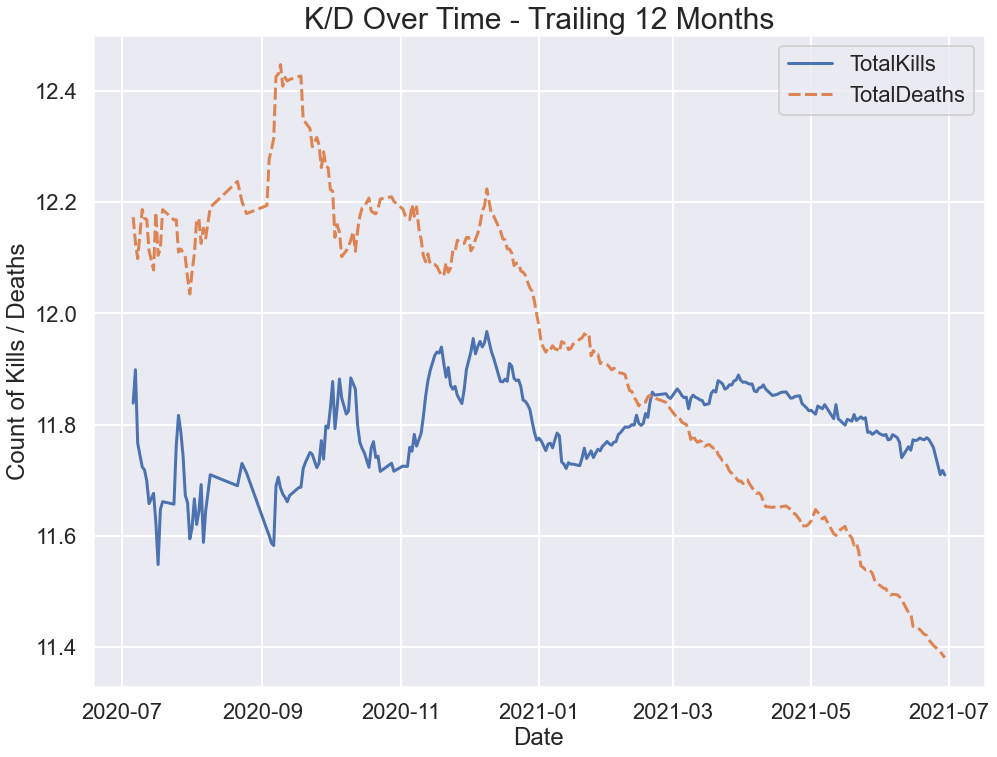

In [46]:
# Reloading dataframe from copy
df = df_kd.copy()

# Function to create line plot for any given column stat in the 'slayer' playlist
# using rolling days smoothing
def stat_lineplot(df, column_list, title, rolling_days=30, 
                  start_date='2020-07-01', end_date='2021-06-30'):
    
    # Choosing 'slayer' gametype
    df = choose_gametype(df, 'Slayer', None)
    
    # Creating 'Day' column
    df['Day'] = df['Date'].dt.date
    df['Day'] = df['Day'].apply(pd.to_datetime)
    
    # Creating groupby dataframe using 'Day' column and implementing rolling days
    # averaging
    df_gb_mean = df.groupby(['Day']).mean()
    df_gb_mean = df_gb_mean.loc[~(df_gb_mean==0).all(axis=1)]
    _grouped = df_gb_mean[column_list].rolling(f'{rolling_days}D').mean()
    df_gb_mean = pd.DataFrame(_grouped)
    
    # Isolating time frame
    df_gb_mean = df_gb_mean[((df_gb_mean.index > start_date) & (df_gb_mean.index < end_date))]
    
    # Creating line plot
    f, ax = plt.subplots(figsize=(16, 12))
    ax = sns.lineplot(data=df_gb_mean, linewidth = 3)
    plt.xlabel('Date')
    ax.set(ylabel='Count of Kills / Deaths')
    ax.set_title(title, fontsize=30)
    
    return ax;
    
column_list = ['TotalKills', 'TotalDeaths']
stat_lineplot(df, column_list, 'K/D Over Time - Trailing 12 Months', 
              start_date='2020-07-05', rolling_days=365)

Here we see my Total Kills plotted against my Total Deaths for every game of Slayer I have played.  

What's interesting is that something must have clicked around March of 2021.  If you remember back to the graph of my wins / losses / ties over time, this might shed more light onto why there were so many games played that month, perhaps I finally felt like I was actually decent at the game.  

What's also interesting is that while the total kills and total deaths gap is gradually widening after March 2021, they are both on a downward trend.  If I had to explain this, I would say that I might have come to the realization that approaching every encounter without tact and consideration puts me at a disadvantage.  In other words, I became a lot more careful and less aggressive.

<AxesSubplot:title={'center':'K/D Over Time - 2021'}, xlabel='Date', ylabel='Count of Kills / Deaths'>

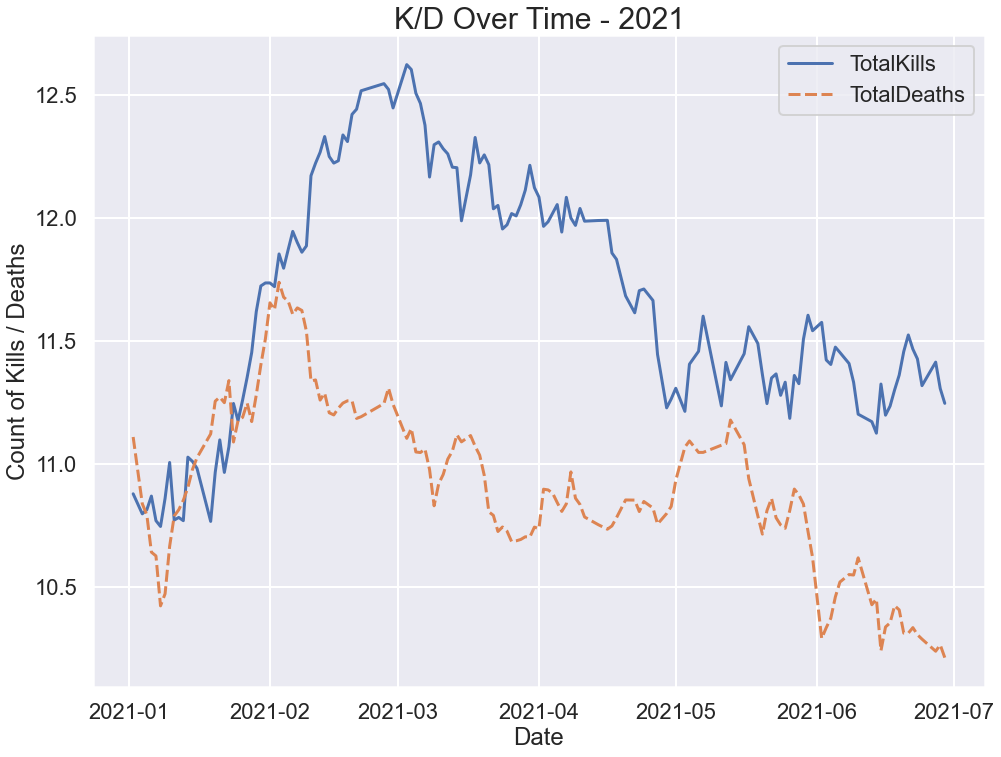

In [47]:
column_list = ['TotalKills', 'TotalDeaths']
stat_lineplot(df, column_list, 'K/D Over Time - 2021', rolling_days=30, 
              start_date='2021-01-01', end_date='2021-06-30')

Taking a closer look at 30 day rolling average between January - June of 2021, you can see that there is a divergence around the beginning of February, which might be closer to when I remapped my buttons on the controller with paddles.  

Sadly, the paddle controller developed an unfixable issue in May of 2021, and you can see that there's a noticeable convergence of total kills and total deaths due to having to relearn pressing all of the buttons with my right thumb as opposed to my left and right index and middle fingers.  It would I receovered somewhat, but had to play a little more conservatively as a result and not take on as many encounters.

<AxesSubplot:title={'center':'Headshot Average Over Time'}, xlabel='Date', ylabel='Count of Kills / Deaths'>

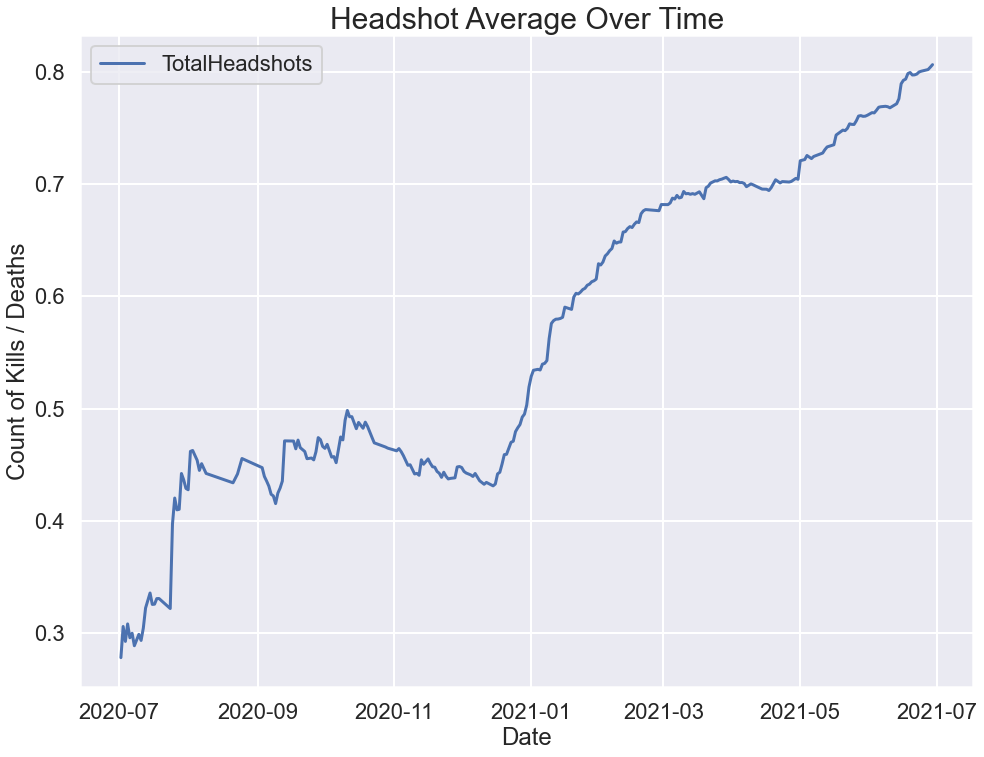

In [48]:
column_list = ['TotalHeadshots']

stat_lineplot(df, column_list, 'Headshot Average Over Time', rolling_days=365)

Headshots over time has a bit of a story as well.  Up until December of 2020, I felt very unskilled with long range weapons.  That Christmas, there was a temporary mode with long range weapons, where hitting a 'headshot' will immediately eliminate the enemy player.  After that mode, I got a better grasp of how that system worked, and I felt more comfortable using long range weapons.  

You'll also notice a plateau between March and May.  My paddled controller that broke in May also had a very tall right thumb stick, which was **supposed to** improve precision and accuracy.  However, I noticed after switching back to the basic controller with the standard right them stick, my accuracy felt like it improved, and I noticed that I was sniping with greater ease.  But I couldn't prove that notion until viewing this data in visual format


If your'e playing against yourself, you don't have to feel bad when you're the worst person on your team.  

# Conclusions and Recommendations

Visuals depicting historical performance and player growth aren't found in many major titles.  After constructing some myself with my own data, I firmly believe that visuals like these are low hanging fruit for developers hoping to increase engagement and player retention.

Exploring K/D improvement over time reaffirms many of the decisions I made while trying to become a better team player.  There is a growing community of creaters on YouTube who specialize in skills, tactics, and controller setting optimization.  The popularity of these channels is surely evidence that gamers do indeed care about becoming better players.  

For example, providing a K/D ratio over time similar to the one I created here but with visual markers indicating controller setting changes, weapon loadout changes, or anything defined by the player could alleviate frustration caused by a sense of failure and defeat when first starting a game.  

Playing devil's advocate, I will admit that providing increased transparency in performance could fuel the ire of this generation's anger with developers and might have the opposite effect.  

I recmmend developers experiment with offering these tools to players.  Properly framed, these visuals could increase satisfaction in more seasoned players and offer guidance to newer players.

# Next Steps

Conducting market research or simply raising the topic on social media or a game's subreddit would offer immediate insight into what players might like to know about their performance.  It would be important to develop an understanding of which visuals are fun and engaging and which visuals could potentially cause more frustration.  

Additionally, on top of personal improvement metrics, there is an abundance of post-match data in Halo 5 that is currently going under-utilized.  Here are a few ideas that could be explored for enhancing the match report:
- 2D / 3D heat maps depicting areas of high activity during the match
- A one dimendsional bar depicting who was in the lead throughout the duration of the match
- Sueprlative awards granted to each player (best long distance, most destruction, best accuracy, e tc.)

# Continued in Modeling Notebook.ipynb...